<p>Ben Trey<br>
Project: Capstone Project 1: Exploratory Data Analysis<br>
Data Science Track<br>
2019/10/16<br>
</p>

<p><b>Overview:</b><br>
This project explores the relationship between individualized education and student growth.<br><br>
    
<b>Question 1:</b><br>
Are there variables that are particularly significant in terms of explaining the answer to your project question?<br>
The variables of interest are the homework grades, the lists of problems given to each student, and the difficulty of each problem.<br> 

<b>Question 2:</b><br>
Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?<br>
There is a strong correlation between the problems chosen and the students homework scores. I examined the effect of giving students problems they got wrong in previous homeworks. As each student has a seperate ability that improves when they complete a problem, I suspected reviewing problems a student got wrong in the previous 3 homeworks would improve their score. I discovered giving the students problems with topics they struggled with caused them to learn at a slower rate. At the end of the semester the final homework showed a statistically signifigant difference between the two methods. 

<b>Question 3:</b><br>
What are the most appropriate tests to use to analyse these relationships?<br>
To test the statistical signifigance between the means of the data sets I used the bootstrap method. 
</p>

<h1>Simulation Code</h1>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import sys
import warnings
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB

<h1>Classes</h1>

In [4]:
directory='/mnt/c/users/我的电脑/desktop/springboard/capstone'

#Student will simulate a students performance 
class Student:
    def __init__(self, school_quality, email):
        #ability represents a student's baseline math skills
        #intelligence represents a student's potential for growth
        #motivation represents a student's motivation for growth 
        #consistency represents a student's consistency in performance
        self.email = email
        self.ability = school_quality - 1.0 + 2.0*np.random.random()
        self.intelligence = school_quality - 1.0 + 2.0*np.random.random()
        self.motivation = school_quality - 1.0 + 2.0*np.random.random()
        self.consistency = school_quality - 1.0 + 2.0*np.random.random()
        self.topics={}
        self.C_list=[1.0,1.0,1.0]
        
    #problemUpdate updates the student's math ability after a correct problem    
    def problem_update(self, correct, topic, old_topic, difficulty):
        if not topic in self.topics:
            self.topics[str(topic)]=-1.0+2.0*np.random.random()
        if not old_topic in self.topics:
            self.topics[str(old_topic)]=-1.0+2.0*np.random.random()
        if correct:
            #increase intelligence with a certain probability
            #increase consistency with a certain probability
            #increase motivation with a certain probability
            if np.exp(self.ability) / (1+np.exp(self.ability)) > np.random.random():
                self.ability = self.ability + difficulty/300.0
            if np.exp(self.intelligence) / (1+np.exp(self.intelligence)) > np.random.random():
                self.intelligence = self.intelligence + difficulty/3000.0
            if np.exp(self.consistency)/(1+np.exp(self.consistency)) > np.random.random():
                self.consistency = self.consistency + difficulty/3000.0
            if np.exp(self.motivation)/(1+np.exp(self.motivation)) > np.random.random():
                self.motivation = self.motivation + difficulty/300.0
            if np.exp(self.topics[topic])/(1+np.exp(self.topics[topic])) >np.random.random():
                self.topics[topic] = self.topics[topic]+difficulty/300.0
            if np.exp(self.topics[old_topic])/(1+np.exp(self.topics[str(old_topic)])) >np.random.random():
                self.topics[old_topic] = self.topics[old_topic]+difficulty/300.0
        else:
            #decrease ability with a certain probability
            #decrease intelligence with a certain probability
            #decrease consistency with a certain probability
            #decrease motivation with a certain probability
            if np.exp(self.ability)/(1+np.exp(self.ability)) < np.random.random():
                self.math_ability = self.ability - difficulty/ 300.0
            if np.exp(self.intelligence)/(1+np.exp(self.intelligence)) < np.random.random():
                self.intelligence = self.intelligence - difficulty/3000.0
            if np.exp(self.consistency)/(1+np.exp(self.consistency)) < np.random.random():
                self.consistency = self.consistency - difficulty/3000.0
            if np.exp(self.motivation)/(1+np.exp(self.motivation)) < np.random.random():
                self.motivation = self.motivation - difficulty/300.0
            if np.exp(self.topics[topic])/(1+np.exp(self.topics[topic])) < np.random.random():
                self.topics[topic] = self.topics[topic] - difficulty/300.0
            if np.exp(self.topics[old_topic])/(1+np.exp(self.topics[old_topic])) < np.random.random():
                self.topics[old_topic] = self.topics[old_topic] - difficulty/300.0

#School is a holder for students
class School:
    def __init__(self,name):
        self.name = name
        self.school_quality=np.random.random()
        self.students = {}

#Homework is a holder for problems
class Homework:
    def __init__(self,number):
        self.number = number
        self.problem_set = []
        self.topics = set()
        
#Problem simulates a problem
class Problem:
    def __init__(self, topic, old_topic, discipline, difficulty):
        self.topic = str(topic)
        self.old_topic = str(old_topic)
        self.discipline = discipline
        self.difficulty = difficulty

#Student_Profile holds the students info seperately from their attributes 
class Student_Profile:
    def __init__(self, real_name, user_name, password, email, school):
        self.real_name = real_name
        self.user_name = user_name
        self.password = password
        self.email = email
        self.school = school 

#Homework_Holder holds the homeworks
class Homework_Holder:
    def __init__(self):
        self.homeworks={}

#user_name_creator makes the user names for the students
def user_name_creator():
    pre=['dank', 'snarky', 'lunar', 'fiesty', 'fruity', 'spicy', 'spikey', 'slippery', 'sleepy', \
        'spooky', 'blinking', 'burping', 'sugary', 'dark', 'dinky', 'droopy', 'blind', 'hairy', \
        'hip', 'lame', 'fiery']
    fix=['tiger', 'shark', 'wheels', 'nightmare', 'guitar', 'pants', 'cat', 'blinker', 'bum', \
        'bacon', 'stinker', 'stripe', 'horse', 'monkey', 'popeye', 'eyes', 'moves', 'figher', \
        'liner', 'drifter', 'docker']
    return np.random.choice(pre) + np.random.choice(fix) + str(np.random.randint(1,1000))

#password_creator makes a password
def password_creator():
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890!@#$%^&*'
    password = ''
    while len(password) < 10:
        password += chars[np.random.randint(0,len(chars)-1)]
    return password

#real_name_creator makes a real name
def real_name_creator():
    first = ['Abe', 'Michael', 'Blanche', 'Bobby', 'Johnny', 'Ryan', 'Jasmine', 'Sarah', 'Jenny', \
        'Josey', 'Eva', 'Wendy', 'Kelly', 'Wayne', 'Larry', 'Cindy', 'Sunny', 'Yolanda', 'Coco', \
        'Helen', 'Barette', 'Judy', 'Teddy', 'Frank', 'Victor', 'Yvonne', 'Howard', 'Richard', \
        'Angel', 'Harry', 'Sammy', 'Alex', 'Albert', 'David', 'Lester', 'Maddy', 'Patrick', \
        'Holly', 'Dan', 'Matt', 'Violet', 'Skylar', 'Patricia', 'Oscar', 'Edgar', 'Owen', 'Eric', \
        'Grace', 'Amy', 'Otto', 'Gunther', 'Franz', 'Lina', 'Nora','Angela', 'Olivia','Oliver']
    last = ['Zhang', 'Zhu', 'Ma', 'Xu', 'Wang', 'Liu', 'Li', 'Lin', 'Smith', 'Jones', 'Jackson', \
        'James', 'Johnson', 'Oneal', 'Riley', 'Maxwell', 'Baker', 'Lenz', 'Goldstein', 'Feldman', \
        'Rothschild', 'Kruger', 'Lowenstein', 'Young', 'Parker', 'Morgan', 'Barker', 'Dunn', \
        'Bradley' 'Woods', 'Jordan', 'McGrady', 'Austin', 'Hogan', 'McGuiness', 'Park']
    return np.random.choice(first) + ' ' + np.random.choice(last)

#email_creator creates an email
def email_creator():
    pre = ['dirty', 'milky', 'fishy', 'slimy', 'used', 'old', 'tired', 'slightly', 'mostly', \
        'found', 'lost', 'new', 'freshy', 'daily', 'buried', 'acient', 'retired', 'deep', 'moist', \
        'dry', 'hot', 'cold', 'folding', 'extra', 'replacement', 'clamy', 'soiled']
    fix = ['bread', 'beans', 'bike', 'tire', 'blanket', 'rug', 'window', 'chrysler', 'jeep', \
        'sub', 'drum', 'snake', 'shoes', 'shirt', 'hat', 'jug', 'shack', 'tide', 'spice', 'cola', \
        'cup', 'skates']
    provider = ['yahoo.com', 'gmail.com', 'outlook.com', 'qq.com', '163.com']
    return np.random.choice(pre) + np.random.choice(fix) + str(np.random.randint(1,1000)) + '@' \
        + np.random.choice(provider)

<h1>Hash Lists</h1>

In [5]:
#creates a homework problem list based on a student
def list_hash(email,number_of_problems,number_to_do):
    problems=[]
    value = hash(email)
    problem_indices = list(range(number_of_problems))
    while len(problems) < number_to_do and len(problem_indices) > 0:
        problems.append(problem_indices.pop(value%len(problem_indices)))
    problems.sort()
    return problems

def list_hash_focus(data_frames, email,number_of_problems,number_to_do,homework_number,homework_data):
    if homework_number<5:
        problems=list_hash(email,number_of_problems,number_to_do)
    else:
        focus_topics=[]
        line=homework_data[homework_data['homework_number']==homework_number]
        possible_problems=list(range(number_of_problems))
        for n in range(3):
            homework_scores = data_frames[n]
            scores=list(homework_scores[homework_scores['email']==email].values[0][1:])
            homework_line=homework_data[homework_data['homework_number']==homework_number-3+n]
            for m in range(len(scores)):
                topic=homework_line['p'+str(m+1)+'t'].values[0]
                old_topic=homework_line['p'+str(m+1)+'ot'].values[0]
                if scores[m]==0 and not topic in focus_topics:
                    focus_topics.append(topic)
                if scores[m]==0 and not old_topic in focus_topics:
                    focus_topics.append(old_topic)
        random.seed(42)
        best_score=0
        problems=[]
        for n in range(10**3):
            test_score=0
            test_problems=random.sample(possible_problems,number_to_do)
            for m in range(number_to_do):
                if line['p'+str(test_problems[m]+1)+'ot'].values[0] in focus_topics:
                    test_score+=1
            if test_score >= best_score:
                best_score=test_score
                problems=test_problems
    return problems

def list_hash_replace(percentages, topics, email, number_of_problems, number_to_do, homework_number):
    problems=[]
    value = hash(email)
    problem_indices = list(range(number_of_problems))
    while len(problems) < number_to_do and len(problem_indices) > 0:
        problems.append(problem_indices.pop(value%len(problem_indices)))
    topics_list = list(percentages.columns)
    remove_list = ['name', 'user_name', 'password', 'school_name']
    topics_list = [topic for topic in topics_list if topic not in remove_list]
    problemic_topics=[[float('inf'), 0], [float('inf'), 0], [float('inf'), 0]]
    for topic in topics_list:
        if float(percentages.loc[email][topic]) < problemic_topics[-1][0]:
             for n in range(number_of_problems):
                    if topics.loc[homework_number]['p'+str(n+1)+'t'] == topic or topics.loc[homework_number]['p'+str(n+1)+'ot'] == topic:
                        if not n+1 in problems:
                            problemic_topics[-1] = [percentages.loc[email][topic],n]
                            problemic_topics.sort()
    for topic in problemic_topics:
        if topic[-1] != 0:
            random.shuffle(problems)
            problems.pop()
            problems.append(topic[-1])
    problems.sort()
    return problems

def list_hash_additional(percentages, topics, email, number_of_problems, number_to_do, homework_number):
    problems=[]
    value = hash(email)
    problem_indices = list(range(number_of_problems))
    while len(problems) < number_to_do and len(problem_indices) > 0:
        problems.append(problem_indices.pop(value%len(problem_indices)))
    topics_list = list(percentages.columns)
    remove_list = ['name', 'user_name', 'password', 'school_name']
    topics_list = [topic for topic in topics_list if topic not in remove_list]
    problemic_topics=[[float('inf'), 0], [float('inf'), 0], [float('inf'), 0]]
    for topic in topics_list:
        if float(percentages.loc[email][topic]) < problemic_topics[-1][0]:
             for n in range(number_of_problems):
                    if topics.loc[homework_number]['p'+str(n+1)+'t'] == topic or topics.loc[homework_number]['p'+str(n+1)+'ot'] == topic:
                        if not n+1 in problems:
                            problemic_topics[-1] = [percentages.loc[email][topic],n]
                            problemic_topics.sort()
    for topic in problemic_topics:
        if topic[-1] != 0:
            problems.append(topic[-1])
    problems.sort()
    return problems

def list_hash_appropriate(email, number_of_problems, number_to_do, homework_number, cdf, cdf_score, problems_cdf):
    if homework_number == 1:
        return hash_list(email, number_of_problems, number_to_do)
    elif homework_number == 51:
        return list(range(20))
    else:
        return problems_cdf[cdf.index(cdf_score)][1]

<h1>Helper Functions</h1>

In [34]:
#standard logistic function
def logistic(value):
    return 1/(1+np.exp(-value))

#problem_grader gives a binary score given a student and a problem
def problem_grader(student, problem):
    #get info from problem
    difficulty=problem.difficulty
    topic=problem.topic
    old_topic=problem.old_topic
    #make sure topic and old topic are in the students topics
    if not topic in student.topics.keys():
        student.topics[topic]=-1+2*np.random.random()
    if not old_topic in student.topics.keys():
        student.topics[old_topic]=-1+2*np.random.random()
    #convert from class parameters to actual parameters using the logistic equation
    motivation_parameter = logistic(student.motivation)
    intelligence_parameter = logistic(student.intelligence)
    consistency_parameter = logistic(student.consistency)
    ability_parameter = logistic(student.ability)
    old_topic_parameter= logistic(student.topics[old_topic])
    topic_parameter = logistic(student.topics[topic])
    return (motivation_parameter*intelligence_parameter*topic_parameter*old_topic_parameter*\
            ability_parameter+(np.random.random()-0.5)/100/consistency_parameter) > (difficulty)**5

#probability_writer finds the probability of getting a problem right and records the result
def probability_writer():
    print('writing probability')
    line1='name'
    line2='name'
    for n in range(1,35):
        line1+=',p'+str(n)
        line2+=',p'+str(n)+'a,p'+str(n)+'c'
    line1+='\r\n'
    line2+='\r\n'
    file_lines1=[line1]
    file_lines2=[line2]
    for homework_number in range(1,51):
        line1='HW'+str(homework_number)
        line2='HW'+str(homework_number)
        data_frame=pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+'.csv')
        for problem_number in range(1,len(data_frame.keys())):
            right=len(data_frame[data_frame['p'+str(problem_number)]==1])
            total=len(data_frame[data_frame['p'+str(problem_number)] != 2])
            line1+=','+str(right/total)
            line2+=','+str(total)+','+str(right)
        line1+='\r\n'
        line2+='\r\n'
        file_lines1.append(line1)
        file_lines2.append(line2)
    file=open(directory+'/hwdata/HW_Probabilities.csv','w+')
    for line in file_lines1:
        file.write(line)
    file.close()
    file=open(directory+'/hwdata/HW_Problem_History.csv','w+')
    for line in file_lines2:
        file.write(line)
    file.close()
    
#data_loader reads data from file and returns the results as a list
def data_loader():
    schools = {}
    students = {}
    student_profiles={}
    homeworks = {}
    data_frame=pd.read_csv(directory+'/hwdata/schools.csv')
    for n in range(data_frame.shape[0]):
        school_name=data_frame.iloc[n]['school_name']
        schools[school_name]=School(school_name)
        schools[school_name].school_quality=data_frame.iloc[n]['school_quality']
    data_frame=pd.read_csv(directory+'/hwdata/students.csv')
    for n in range(data_frame.shape[0]):
        email=data_frame.iloc[n]['email']
        students[email]=Student(0,email)
        students[email].ability=data_frame.iloc[n]['ability']
        students[email].intelligence=data_frame.iloc[n]['intelligence']
        students[email].motivation=data_frame.iloc[n]['motivation']
        students[email].consistency=data_frame.iloc[n]['consistency']
    data_frame=pd.read_csv(directory+'/hwdata/students_profile.csv')
    for n in range(data_frame.shape[0]):
        school_name=data_frame.iloc[n]['school_name']
        email=data_frame.iloc[n]['email']
        schools[school_name].students[email]=students[email]
    for n in range(data_frame.shape[0]):
        email=data_frame.iloc[n]['email']
        real_name=data_frame.iloc[n]['name']
        user_name=data_frame.iloc[n]['user_name']
        password=data_frame.iloc[n]['password']
        school_name=data_frame.iloc[n]['school_name']
        student_profiles[email]=Student_Profile(real_name,user_name,password,email,school_name)
    data_frame=pd.read_csv(directory+'/hwdata/HWS.csv')
    for n in range(51):
        homeworks[str(n+1)]=Homework(n+1)
        number_of_problems=data_frame.iloc[n]['number_of_problems']
        for m in range(number_of_problems):
            topic=str(data_frame.iloc[n]['p'+str(m+1)+'t'])
            old_topic=data_frame.iloc[n]['p'+str(m+1)+'t']
            discipline=data_frame.iloc[n]['p'+str(m+1)+'ds']
            difficulty=data_frame.iloc[n]['p'+str(m+1)+'d']
            homeworks[str(n+1)].topics.add(topic)
            problem=Problem(topic,old_topic,discipline,difficulty)
            homeworks[str(n+1)].problem_set.append(problem)
    return [schools,students,student_profiles,homeworks]   

def get_grades(extension=''):
    grades=[]
    data=data_loader()
    students=data[1]
    homeworks=data[0]
    for n in range(len(homeworks.keys())):
        for email in students.keys():
            grades.append(get_grade(students[email],n+1,extension))
    return grades

#get_grade gets a grade for a homework completed by a student
def get_grade(student, homework_number, extension):
    #get_grade reads the grade from a csv file and returns a score out of 10
    email=student.email
    homework_data_frame=pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+extension+'.csv')
    student_data_frame=homework_data_frame[homework_data_frame['email']==email]
    points=0
    total=0
    for key in student_data_frame.keys():
        if student_data_frame.iloc[0][key] == 1:
            points+=1
            total+=1
        if student_data_frame.iloc[0][key] == 0:
            total+=1
    return points/total*10
    
def get_grades_total():
    grades=[]
    data=data_loader_focus()
    students=data[1]
    homeworks=data[0]
    for n in range(len(homeworks.keys())):
        for email in students.keys():
            grades.append(get_grade(students[email],n+1,'_focus'))
            grades.append(get_grade(students[email],n+1))
    return grades

def get_grades(extension=''):
    grades=[]
    data=data_loader()
    students=data[1]
    homeworks=data[0]
    for n in range(len(homeworks.keys())):
        for email in students.keys():
            grades.append(get_grade(students[email],n+1,extension))
    return grades

def get_grade(student,homework_number,extension):
    #get_grade reads the grade from a csv file and returns a score out of 10
    email=student.email
    homework_data_frame=pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+extension+'.csv')
    student_data_frame=homework_data_frame[homework_data_frame['email']==email]
    points=0
    total=0
    for key in student_data_frame.keys():
        if student_data_frame.iloc[0][key] == 1:
            points+=1
            total+=1
        if student_data_frame.iloc[0][key] == 0:
            total+=1
    return points/total*10

def data_frame_maker(simulation_type=''):
    df_scores = pd.read_csv(directory + '/hwdata/students_profile.csv', index_col='email')
    emails = df_scores.index
    for homework_number in tqdm(range(1,52)):
        df_scores['score_'+str(homework_number)] = 0.0
        df_homework = pd.read_csv(directory + '/hwdata/HW'+str(homework_number)+\
                                   simulation_type+'.csv', index_col='email')
        columns = df_homework.columns
        for email in emails:
            points = 0
            problems = 0
            for column in columns:
                score = df_homework.loc[email][column]
                if score == 1 or score == 0:
                    problems += 1
                if score == 1:
                    points += 1
            df_scores.at[email, 'score_'+str(homework_number)] = 10*points/problems
    df_scores = df_scores.reset_index()
    return df_scores

def data_frame_maker_topics():
    df = pd.read_csv(directory + '/hwdata/students_profile.csv', index_col='email')
    df_hws = pd.read_csv(directory + '/hwdata/HWS.csv', index_col='homework_number')
    columns = list(df_hws.columns)
    for n in range(1,35):
        columns.remove('p'+str(n)+'t')
        columns.remove('p'+str(n)+'ot')
    df_hws = df_hws.drop(columns=columns)
    return df_hws

def data_frame_maker_percentages(number_of_homeworks, simulation_type=''):
    df = pd.read_csv(directory + '/hwdata/students_profile.csv', index_col='email')
    df_topics = data_frame_maker_topics()
    df_topics = df_topics.replace({'pre1':'0.1', 'pre2':'0.2', 'pre3':'0.3', 'pre4':'0.4', 'pre5':'0.5'}, regex=True)
    topics = []
    for homework_number in range(1,number_of_homeworks+1):
        for column in df_topics.columns:
            topic = df_topics.loc[homework_number][column]
            if not str(topic) in topics and str(topic) != 'nan':
                topics.append(str(topic))
    topics.sort()
    scores = {}
    emails = df.index
    for homework_number in range(1,number_of_homeworks+1):
        df_scores = pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+simulation_type+'.csv', index_col='email')
        columns = df_scores.columns
        for column in columns:
            topic = df_topics.loc[homework_number][column+'t']
            old_topic = df_topics.loc[homework_number][column+'ot']
            for email in emails:
                score = df_scores.loc[email][column]
                if scores.get(email+'_'+str(topic)+'_attempts', -1) == -1:
                    scores[email+'_'+str(topic)+'_attempts'] = 0
                    scores[email+'_'+str(topic)+'_points'] = 0
                if scores.get(email+'_'+str(old_topic)+'_attempts', -1) == -1:
                    scores[email+'_'+str(old_topic)+'_attempts'] = 0
                    scores[email+'_'+str(old_topic)+'_points'] = 0
                if score == 1 or score == 0:
                    scores[email+'_'+str(topic)+'_attempts'] += 1
                    scores[email+'_'+str(old_topic)+'_attempts'] += 1
                if score == 1:
                    scores[email+'_'+str(topic)+'_points'] += 1
                    scores[email+'_'+str(old_topic)+'_points'] += 1
    percentages = df
    for topic in topics:
        percentages[topic] = 0.0
        for email in emails:
            if scores[email+'_'+topic+'_attempts'] != 0:
                percentages.at[email, topic] = scores[email+'_'+topic+'_points']/scores[email+'_'+topic+'_attempts']
    return percentages

homeworks = {}

def data_frame_homework_percentages(number_of_homeworks, simulation_type=''):
    df = pd.read_csv(directory + '/hwdata/students_profile.csv', index_col='email')
    df_grades = pd.DataFrame(df.index)
    df_grades = df_grades.set_index('email')
    emails = df.index
    df_grades['Average'] = 0.0
    global homeworks
    for homework_number in range(1,number_of_homeworks+1):
        df_homework = homeworks.get(str(homework_number)+simulation_type, pd.DataFrame()) 
        if df_homework.size == 0:
            homeworks[str(homework_number)+simulation_type] = pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+simulation_type+'.csv', index_col='email')
            df_homework = homeworks[str(homework_number)+simulation_type]
        columns = df_homework.columns
        for email in emails:
            points = 0
            problems = 0
            for column in columns:
                score = df_homework.loc[email][column]
                if score == 0 or score == 1:
                    problems += 1
                if score == 1:
                    points += 1
            df_grades.at[email,'Average'] = df_grades.loc[email]['Average']+10*points/problems
    for email in emails:
        df_grades.at[email, 'Average'] = df_grades.loc[email]['Average']/number_of_homeworks
    return df_grades

def data_frame_skills_by_homework():
    data = []
    data_focus = []
    data_additional = []
    data_replace = []
    data_appropriate = []
    for homework_number in tqdm(range(6,51)):
        temp_data = data_frame_homework_percentages(homework_number)
        data.append(temp_data.stack().mean())
        temp_data = data_frame_homework_percentages(homework_number, '_focus')
        data_focus.append(temp_data.stack().mean())
        temp_data = data_frame_homework_percentages(homework_number, '_additional')
        data_additional.append(temp_data.stack().mean())
        temp_data = data_frame_homework_percentages(homework_number, '_replace')
        data_replace.append(temp_data.stack().mean())
        temp_data = data_frame_homework_percentages(homework_number, '_appropriate')
        data_appropriate.append(temp_data.stack().mean())
    return [list(range(6,51)), data, data_focus, data_additional, data_replace, data_appropriate]

def data_frame_homework_score(homework_number, simulation_type=''):
    df = pd.read_csv(directory + '/hwdata/students_profile.csv', index_col='email')
    df_grades = pd.DataFrame(df.index)
    df_grades = df_grades.set_index('email')
    emails = df.index
    df_grades['Score'] = 0.0
    df_homework = pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+simulation_type+'.csv', index_col='email')
    columns = df_homework.columns
    for email in emails:
        points = 0
        problems = 0
        for column in columns:
            score = df_homework.loc[email][column]
            if score == 0 or score ==1:
                problems += 1
            if score == 1:
                points += 1
        df_grades.at[email,'Score'] = 10*points/problems
    return df_grades

def data_frame_grade_by_homework():
    data = []
    data_focus = []
    data_additional = []
    data_replace = []
    data_appropriate = []
    for homework_number in tqdm(range(1,51)):
        temp_data = data_frame_homework_score(homework_number)
        data.append(temp_data.Score.mean())
        temp_data = data_frame_homework_score(homework_number, '_focus')
        data_focus.append(temp_data.Score.mean())
        temp_data = data_frame_homework_score(homework_number, '_additional')
        data_additional.append(temp_data.Score.mean())
        temp_data = data_frame_homework_score(homework_number, '_replace')
        data_replace.append(temp_data.Score.mean())
        temp_data = data_frame_homework_score(homework_number, '_appropriate')
        data_appropriate.append(temp_data.Score.mean())
    return [list(range(1,51)), data, data_focus, data_additional, data_replace, data_appropriate]


<h1>Simulations</h1>

In [7]:
#data_maker simulates a year of grades and records the results
def data_maker():
    print('making data')
    schools = {}
    students = {}
    homework = {}
    #populate schools dictionary and write csv
    school_names = ['Chandler', 'Ahwatukee', 'Scottsdale', 'Phoenix', 'Dallas', 'Washington D.C.', \
        'Beijing', 'Shanghai', 'Bangkok', 'Mesa']
    file=open(directory+'/hwdata/schools.csv','w+')
    file.write('school_name,school_quality\r\n')
    for name in school_names:
        schools[name]=School(name)
        file.write(name+', '+str(schools[name].school_quality)+'\r\n')
    file.close()
    #populate students and school.students, write student.csv
    file=open(directory+'/hwdata/students.csv','w+')
    file.write('email,ability,intelligence,motivation,consistency\r\n')
    for name in schools.keys():
        number_of_students = 80 + np.random.randint(0,40)
        school_quality = schools[name].school_quality
        for n in range(number_of_students):
            email = email_creator()
            while email in students.keys():
                email = email_creator()
            real_name = real_name_creator()
            user_name = user_name_creator()
            password = password_creator()
            schools[name].students[email]=Student_Profile(real_name, user_name, password, email, \
                name)
            students[email]=Student(school_quality, email)
            file.write(email+','+str(students[email].ability)+','+str(students[email].intelligence)\
                +','+str(students[email].motivation)+','+str(students[email].consistency)+'\r\n')
    file.close()
    #write student info
    file=open(directory+'/hwdata/students_profile.csv','w+')
    file.write('name,user_name,password,email,school_name\r\n')
    for name in schools.keys():
        for email in schools[name].students.keys():
            real_name=schools[name].students[email].real_name
            user_name=schools[name].students[email].user_name
            password=schools[name].students[email].password
            file.write(real_name+','+user_name+','+password+','+email+','+name+'\r\n')
    file.close()
    #populate homework problems
    difficulties= [ [] for n in range(51) ]
    topics=set(['pre1','pre2','pre3','pre4','pre5'])
    for n in range(51):
        homework[n+1] = Homework(n+1)
        if n != 50:
            number_to_do = 7 + np.random.randint(0,10)
            number_of_problems = 2*number_to_do
        else:
            number_to_do = 20
            number_of_problems = 20
        chapter = int(n/5) + 1
        for m in range(number_of_problems):
            if n != 50:
                topic = str(chapter) + '.' + str(6*n%10 + int(m/6))
                old_topic=random.sample(topics,1)[0]
            else:
                temp_topics = random.sample(topics,2)
                topic = temp_topics[0]
                old_topic = temp_topics[1]
            homework[n+1].topics.add(topic)
            difficulty = np.random.normal(0.5,0.10)
            difficulties[n].append(topic)
            difficulties[n].append(old_topic)
            difficulties[n].append('none')
            difficulties[n].append(str(difficulty))
            homework[n+1].problem_set.append(Problem(topic, old_topic, 'none', difficulty))
        for topic in homework[n+1].topics:
            topics.add(topic)
    #simulate homework problems
    line='homework_number,number_of_problems_to_do,number_of_problems'
    for n in range(1,35):
        line+=',p'+str(n)+'t,p'+str(n)+'ot,p'+str(n)+'ds,p'+str(n)+'d'
    line+='\r\n'
    homework_info_lines=[line]
    for homework_number in tqdm(range(1,52)):
        file_lines = []
        grade_lines = []
        if homework_number != 51:
            number_of_problems = len(homework[homework_number].problem_set)
            problems_to_do = int(number_of_problems/2)
        else:
            number_of_problems = 20
            number_to_do = 20
        line=str(homework_number) + ',' + str(problems_to_do) + ',' \
            + str(number_of_problems)
        for problem_number in range(number_of_problems):
            topic=homework[homework_number].problem_set[problem_number].topic
            old_topic=homework[homework_number].problem_set[problem_number].old_topic
            discipline=homework[homework_number].problem_set[problem_number].discipline
            difficulty=homework[homework_number].problem_set[problem_number].difficulty
            line+=','+topic+','+old_topic+','+discipline+','+str(difficulty)
        line+='\r\n'
        homework_info_lines.append(line)
        file_columns='email'
        for n in range(number_of_problems):
            file_columns+=(',p'+str(n+1))
        file_columns+='\r\n'
        file_lines.append(file_columns)
        for school_name in schools.keys():
            for email in schools[school_name].students.keys():
                problems_for_student = list_hash(email,number_of_problems,problems_to_do)
                scores = ['2' for n in range(number_of_problems)]
                for index in problems_for_student:
                    topic=homework[homework_number].problem_set[index].topic
                    old_topic=homework[homework_number].problem_set[index].old_topic
                    difficulty=homework[homework_number].problem_set[index].difficulty
                    score=problem_grader(students[email],\
                        homework[homework_number].problem_set[index])
                    students[email].problem_update(score,topic,old_topic,difficulty)
                    #second attempt
                    if score == False:
                        score=problem_grader(students[email],homework[homework_number].problem_set[index])
                        students[email].problem_update(score,topic,old_topic,difficulty)
                    scores[index]=str(int(score))
                grade_lines.append(email+','+','.join(scores)+'\r\n')
                #improving ability based on results
                for index in problems_for_student:
                    students[email].problem_update(scores[index],topic,old_topic,\
                        homework[homework_number].problem_set[index].difficulty)
        while len(grade_lines)>1:
            file_lines.append(grade_lines.pop(np.random.randint(0,len(grade_lines)-1)))
        file_lines.append(grade_lines.pop())
        file = open(directory+'/hwdata/HW' + str(homework_number) + '.csv','w+')
        for line in file_lines:
            file.write(line)
        file.close()
    file=open(directory+'/hwdata/HWS.csv','w+')
    for line in homework_info_lines:
        file.write(line)
    file.close()
    probability_writer()
    student_file_lines=[]
    student_file = open(directory+'/hwdata/final_students.csv','w+')
    student_file.write('email, ability, intelligence, motivation, consistency, topics')
    for email, student in students.items():
        student_file.write(email + ', ' + str(student.ability) + ', ' + str(student.intelligence) + ', ' +\
                           str(student.motivation) + ', ' + str(student.consistency) + ', ' +\
                           str(student.topics) + '\r\n')
    student_file.close()

def data_maker_focus():
    print('making data')
    data_loaded=data_loader()
    schools=data_loaded[0]
    students=data_loaded[1]
    student_profiles=data_loaded[2]
    homework=data_loaded[3]
    homework_data=pd.read_csv(directory+'/hwdata/HWS.csv')
    #simulate homework problems
    for homework_number in tqdm(range(1,52)):
        file_lines = []
        grade_lines = []
        if homework_number != 51:
            number_of_problems = len(homework[str(homework_number)].problem_set)
            problems_to_do = int(number_of_problems/2)
        else:
            number_of_problems = 20
            number_to_do = 20
        file_columns='email'
        for n in range(number_of_problems):
            file_columns+=(',p'+str(n+1))
        file_columns+='\r\n'
        file_lines.append(file_columns)
        if homework_number>4:
            data_frames=[pd.read_csv(directory+'/hwdata/HW'+str(homework_number-3)+'_focus.csv'),\
                        pd.read_csv(directory+'/hwdata/HW'+str(homework_number-2)+'_focus.csv'),\
                        pd.read_csv(directory+'/hwdata/HW'+str(homework_number-1)+'_focus.csv')]
        else:
            data_frames=[]
        for school_name in schools.keys():
            for email in schools[school_name].students.keys():
                problems_for_student = list_hash_focus(data_frames, email, number_of_problems, problems_to_do,\
                                                       homework_number, homework_data)
                scores = ['2' for n in range(number_of_problems)]
                for index in problems_for_student:
                    topic=homework[str(homework_number)].problem_set[index].topic
                    old_topic=homework[str(homework_number)].problem_set[index].old_topic
                    difficulty=homework[str(homework_number)].problem_set[index].difficulty
                    score=problem_grader(students[email],\
                        homework[str(homework_number)].problem_set[index])
                    students[email].problem_update(score,topic,old_topic,difficulty)
                    #second attempt
                    if score == False:
                        score=problem_grader(students[email],homework[str(homework_number)].problem_set[index])
                        students[email].problem_update(score,topic,old_topic,difficulty)
                    scores[index]=str(int(score))
                grade_lines.append(email+','+','.join(scores)+'\r\n')
                #improving ability based on results
                for index in problems_for_student:
                    students[email].problem_update(scores[index],topic,old_topic,\
                        homework[str(homework_number)].problem_set[index].difficulty)
        while len(grade_lines)>1:
            file_lines.append(grade_lines.pop(np.random.randint(0,len(grade_lines)-1)))
        file_lines.append(grade_lines.pop())
        file = open(directory+'/hwdata/HW' + str(homework_number) + '_focus.csv','w+')
        for line in file_lines:
            file.write(line)
        file.close()
    student_file_lines=[]
    student_file = open(directory+'/hwdata/final_students_focus.csv','w+')
    student_file.write('email, ability, intelligence, motivation, consistency, topics')
    for email, student in students.items():
        student_file.write(email + ', ' + str(student.ability) + ', ' + str(student.intelligence) + ', ' +\
                           str(student.motivation) + ', ' + str(student.consistency) + ', ' +\
                           str(student.topics) + '\r\n')
    student_file.close()        

def data_maker_additional():
    print('making data')
    data_loaded=data_loader()
    topics = data_frame_maker_topics()
    schools=data_loaded[0]
    students=data_loaded[1]
    student_profiles=data_loaded[2]
    homework=data_loaded[3]
    homework_data=pd.read_csv(directory+'/hwdata/HWS.csv')
    #simulate homework problems
    for homework_number in tqdm(range(1,52)):
        percentages = data_frame_maker_percentages(homework_number-1, simulation_type='_additional')
        file_lines = []
        grade_lines = []
        if homework_number != 51:
            number_of_problems = len(homework[str(homework_number)].problem_set)
            problems_to_do = int(number_of_problems/2)
        else:
            number_of_problems = 20
            number_to_do = 20
        file_columns='email'
        for n in range(number_of_problems):
            file_columns+=(',p'+str(n+1))
        file_columns+='\r\n'
        file_lines.append(file_columns)
        for school_name in schools.keys():
            for email in schools[school_name].students.keys():
                problems_for_student = list_hash_additional(percentages, topics, email, number_of_problems, problems_to_do, homework_number)
                scores = ['2' for n in range(number_of_problems)]
                for index in problems_for_student:
                    topic=homework[str(homework_number)].problem_set[index].topic
                    old_topic=homework[str(homework_number)].problem_set[index].old_topic
                    difficulty=homework[str(homework_number)].problem_set[index].difficulty
                    score=problem_grader(students[email],\
                        homework[str(homework_number)].problem_set[index])
                    students[email].problem_update(score,topic,old_topic,difficulty)
                    #second attempt
                    if score == False:
                        score=problem_grader(students[email],homework[str(homework_number)].problem_set[index])
                        students[email].problem_update(score,topic,old_topic,difficulty)
                    scores[index]=str(int(score))
                grade_lines.append(email+','+','.join(scores)+'\r\n')
                #improving ability based on results
                for index in problems_for_student:
                    students[email].problem_update(scores[index],topic,old_topic,\
                        homework[str(homework_number)].problem_set[index].difficulty)
        while len(grade_lines)>1:
            file_lines.append(grade_lines.pop(np.random.randint(0,len(grade_lines)-1)))
        file_lines.append(grade_lines.pop())
        file = open(directory+'/hwdata/HW' + str(homework_number) + '_additional.csv','w+')
        for line in file_lines:
            file.write(line)
        file.close()
    student_file_lines=[]
    student_file = open(directory+'/hwdata/final_students_additional.csv','w+')
    student_file.write('email, ability, intelligence, motivation, consistency, topics')
    for email, student in students.items():
        student_file.write(email + ', ' + str(student.ability) + ', ' + str(student.intelligence) + ', ' +\
                           str(student.motivation) + ', ' + str(student.consistency) + ', ' +\
                           str(student.topics) + '\r\n')
    student_file.close()

def data_maker_replace():
    print('making data')
    data_loaded=data_loader()
    topics = data_frame_maker_topics()
    schools=data_loaded[0]
    students=data_loaded[1]
    student_profiles=data_loaded[2]
    homework=data_loaded[3]
    homework_data=pd.read_csv(directory+'/hwdata/HWS.csv')
    #simulate homework problems
    for homework_number in tqdm(range(1,52)):
        percentages = data_frame_maker_percentages(homework_number-1, simulation_type='_replace')
        file_lines = []
        grade_lines = []
        if homework_number != 51:
            number_of_problems = len(homework[str(homework_number)].problem_set)
            problems_to_do = int(number_of_problems/2)
        else:
            number_of_problems = 20
            number_to_do = 20
        file_columns='email'
        for n in range(number_of_problems):
            file_columns+=(',p'+str(n+1))
        file_columns+='\r\n'
        file_lines.append(file_columns)
        for school_name in schools.keys():
            for email in schools[school_name].students.keys():
                problems_for_student = list_hash_replace(percentages, topics, email, number_of_problems, problems_to_do, homework_number)
                scores = ['2' for n in range(number_of_problems)]
                for index in problems_for_student:
                    topic=homework[str(homework_number)].problem_set[index].topic
                    old_topic=homework[str(homework_number)].problem_set[index].old_topic
                    difficulty=homework[str(homework_number)].problem_set[index].difficulty
                    score=problem_grader(students[email],\
                        homework[str(homework_number)].problem_set[index])
                    students[email].problem_update(score,topic,old_topic,difficulty)
                    #second attempt
                    if score == False:
                        score=problem_grader(students[email],homework[str(homework_number)].problem_set[index])
                        students[email].problem_update(score,topic,old_topic,difficulty)
                    scores[index]=str(int(score))
                grade_lines.append(email+','+','.join(scores)+'\r\n')
                #improving ability based on results
                for index in problems_for_student:
                    students[email].problem_update(scores[index],topic,old_topic,\
                        homework[str(homework_number)].problem_set[index].difficulty)
        while len(grade_lines)>1:
            file_lines.append(grade_lines.pop(np.random.randint(0,len(grade_lines)-1)))
        file_lines.append(grade_lines.pop())
        file = open(directory+'/hwdata/HW' + str(homework_number) + '_replace.csv','w+')
        for line in file_lines:
            file.write(line)
        file.close()
    student_file_lines=[]
    student_file = open(directory+'/hwdata/final_students_replace.csv','w+')
    student_file.write('email, ability, intelligence, motivation, consistency, topics')
    for email, student in students.items():
        student_file.write(email + ', ' + str(student.ability) + ', ' + str(student.intelligence) + ', ' +\
                           str(student.motivation) + ', ' + str(student.consistency) + ', ' +\
                           str(student.topics) + '\r\n')
    student_file.close()

def data_maker_appropriate():
    print('making data')
    data_loaded=data_loader()
    topics = data_frame_maker_topics()
    schools=data_loaded[0]
    students=data_loaded[1]
    student_profiles=data_loaded[2]
    homework=data_loaded[3]
    homework_data=pd.read_csv(directory+'/hwdata/HWS.csv')
    #simulate homework problems
    for homework_number in tqdm(range(1,52)):
        file_lines = []
        grade_lines = []
        if homework_number != 51:
            number_of_problems = len(homework[str(homework_number)].problem_set)
            problems_to_do = int(number_of_problems/2)
        else:
            number_of_problems = 20
            number_to_do = 20
        file_columns='email'
        for n in range(number_of_problems):
            file_columns+=(',p'+str(n+1))
        file_columns+='\r\n'
        file_lines.append(file_columns)
        cdf = []
        problems_cdf = []
        if homework_number > 1 and homework_number < 51:
            data_frame = data_frame_homework_percentages(homework_number-1, '_appropriate')
            for email in data_frame.index:
                cdf.append(data_frame.loc[email]['Average'])
                homework_set = list_hash(email, number_of_problems, problems_to_do)
                set_difficulty = 0
                for index in homework_set:
                    set_difficulty += homework[str(homework_number)].problem_set[index].difficulty
                problems_cdf.append([set_difficulty, homework_set])
            cdf.sort()
            problems_cdf.sort()
        for school_name in schools.keys():
            for email in schools[school_name].students.keys():
                if homework_number != 1:
                    cdf_score = cdf.index(data_frame.loc[email]['Average'])
                else:
                    cdf_score = 0
                problems_for_student = list_hash_appropriate(email, number_of_problems, problems_to_do, homework_number, cdf, cdf_score, problems_cdf)
                scores = ['2' for n in range(number_of_problems)]
                for index in problems_for_student:
                    topic=homework[str(homework_number)].problem_set[index].topic
                    old_topic=homework[str(homework_number)].problem_set[index].old_topic
                    difficulty=homework[str(homework_number)].problem_set[index].difficulty
                    score=problem_grader(students[email],\
                        homework[str(homework_number)].problem_set[index])
                    students[email].problem_update(score,topic,old_topic,difficulty)
                    #second attempt
                    if score == False:
                        score=problem_grader(students[email],homework[str(homework_number)].problem_set[index])
                        students[email].problem_update(score,topic,old_topic,difficulty)
                    scores[index]=str(int(score))
                grade_lines.append(email+','+','.join(scores)+'\r\n')
                #improving ability based on results
                for index in problems_for_student:
                    students[email].problem_update(scores[index],topic,old_topic,\
                        homework[str(homework_number)].problem_set[index].difficulty)
        while len(grade_lines)>1:
            file_lines.append(grade_lines.pop(np.random.randint(0,len(grade_lines)-1)))
        file_lines.append(grade_lines.pop())
        file = open(directory+'/hwdata/HW' + str(homework_number) + '_appropriate.csv','w+')
        for line in file_lines:
            file.write(line)
        file.close()
    student_file_lines=[]
    student_file = open(directory+'/hwdata/final_students_appropriate.csv','w+')
    student_file.write('email, ability, intelligence, motivation, consistency, topics')
    for email, student in students.items():
        student_file.write(email + ', ' + str(student.ability) + ', ' + str(student.intelligence) + ', ' +\
                           str(student.motivation) + ', ' + str(student.consistency) + ', ' +\
                           str(student.topics) + '\r\n')
    student_file.close()

<h1>Graph Makers</h1>

In [20]:
def just_make_a_graph(grades, title):
    print('mean with all grades',sum(grades)/len(grades))
    plt.hist(grades,bins=20)
    plt.title(title)
    plt.xlabel('Grades')
    plt.ylabel('Occurences')
    plt.show()
    
def just_make_a_log_graph(grades, title):
    print('mean with all grades',sum(grades)/len(grades))
    log_average_grades = np.log(10.1 - grades)
    plt.hist(log_average_grades)
    plt.title(title)
    plt.xlabel('Grades')
    plt.ylabel('Occurences')
    plt.show()
    
def graph_grades_progression(data, title):
    time = data[0]
    data_series = data[1:] 
    labels=['Random', 'Focus', 'Additional', 'Replacement', 'Appropriate']
    for n in range(5):
        datum = data_series[n]
        plt.plot(time, datum, label=labels[n])
    plt.legend(loc="upper left")
    plt.title(title)
    plt.xlabel('Homework Number')
    plt.ylabel('Average Grade')
    plt.show()

def graph_skills_progression(data, title):
    time = data[0]
    data_series = data[1:] 
    labels=['Random', 'Focus', 'Additional', 'Replacement', 'Appropriate']
    for n in range(5):
        datum = data_series[n]
        plt.plot(time, datum, label=labels[n])
    plt.legend(loc="upper left")
    plt.title(title)
    plt.xlabel('Homework Number')
    plt.ylabel('Average Skill Score')
    plt.show()

def student_help_plot(email, homework_number, simulation_type=''):
    if homework_number < 5:
        print("You have not completed enough homework for analysis.")
    else:
        scores = data_frame_maker_percentages(homework_number, simulation_type)
        scores = scores.drop(['name', 'user_name', 'password', 'school_name'], axis=1)
        max_topic = [-float('inf'), 'topic']
        min_topic = [float('inf'), 'topic']
        topics_rank = [[-float('inf'), 'topic'], [-float('inf'), 'topic'], [-float('inf'), 'topic']]
        for column in scores.columns:
            student_value = scores.loc[email][column]
            column_list = list(scores[column].values)
            column_list.sort()
            cdf = column_list.index(student_value)/len(column_list)
            if max_topic[0] < cdf:
                max_topic = [cdf, column]
            if min_topic[0] > cdf:
                min_topic = [cdf, column]
            if topics_rank[0][0] < abs(cdf-0.5):
                topics_rank[0] = [abs(cdf-0.5), column]
                topics_rank.sort()
        topics = [max_topic[1],min_topic[1]]
        while len(topics) < 3: 
            topic = topics_rank.pop(0)[1]
            if not topic in topics:
                topics.append(topic)
        percentages = [list(scores[topics[0]]), list(scores[topics[1]]), list(scores[topics[2]])]
        points = [scores.loc[email][topics[0]], scores.loc[email][topics[1]], scores.loc[email][topics[2]]]
        fig, ax = plt.subplots()
        plt.boxplot(percentages) 
        plt.title('Your Scores Superimposed on Class Data')
        plt.xlabel('Topics')
        ax.set_xticklabels(topics)
        plt.ylabel('Ratio of Correct Problems')
        h, = plt.plot(range(1,4), points, 'go', ms=15)
        plt.legend([h],['Your Score'], numpoints=1)
        plt.show()

<h1>Making Data</h1>

In [210]:
#data was made
#data_maker()

<h1>Determining Location from Grades</h1>

In [9]:
df = data_frame_maker()

In [115]:
df.head()

,email,name,user_name,password,school_name,score_1,score_2,score_3,score_4,score_5,...,score_42,score_43,score_44,score_45,score_46,score_47,score_48,score_49,score_50,score_51
0,buriedwindow162@163.com,Josey Feldman,slipperydocker973,DKsLOANYx6,Chandler,8.125,7.777778,8.461538,9.0,10.000,...,10.000000,9.333333,10.0,10.000000,10.0,10.000000,9.0,10.0,10.000000,7.142857
1,buriedshoes89@gmail.com,Sarah Morgan,fiestyshark715,XRcE9vz8Lf,Chandler,6.250,7.777778,7.692308,8.0,5.000,...,8.181818,8.000000,10.0,7.777778,8.0,10.000000,8.0,9.0,8.571429,8.571429
2,soiledchrysler517@163.com,Jenny Dunn,snarkyhorse863,H3AnnRHKk7,Chandler,7.500,7.777778,7.692308,9.0,8.125,...,8.181818,8.000000,9.0,10.000000,10.0,6.923077,10.0,9.0,8.571429,10.000000
3,clamydrum151@yahoo.com,Abe Young,dankguitar992,NkF@Knwh%3,Chandler,5.000,5.555556,8.461538,8.0,6.875,...,8.181818,10.000000,10.0,10.000000,8.0,7.692308,7.0,10.0,7.142857,10.000000
4,replacementblanket359@outlook.com,Yolanda Parker,hipbacon727,iUXON1hSGn,Chandler,9.375,7.777778,8.461538,9.0,8.125,...,9.090909,10.000000,10.0,8.888889,10.0,10.000000,8.0,8.0,7.142857,10.000000


In [116]:
df['school_name'].unique()

array(['Chandler', 'Ahwatukee', 'Scottsdale', 'Phoenix', 'Dallas',
       'Washington D.C.', 'Beijing', 'Shanghai', 'Bangkok', 'Mesa'],
      dtype=object)

In [117]:
df = df.drop(['email', 'name', 'user_name', 'password'], axis=1)
df = df.replace({'Chandler':0, 'Ahwatukee':1, 'Scottsdale':2, 'Phoenix':3,\
                 'Dallas':4, 'Washington D.C.':5, 'Beijing':6, 'Shanghai':7,\
                 'Bangkok':8, 'Mesa':9})

mean with all grades 7.793287240938501


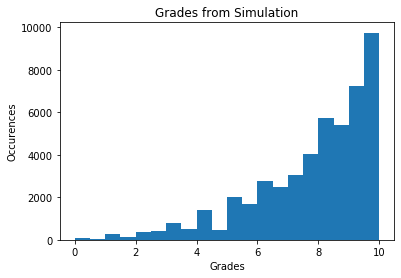

In [141]:
grades = list(df.drop(['school_name'], axis=1).stack())
just_make_a_graph(grades, 'Grades from Simulation')

In [118]:
y = df['school_name']
X = df.drop(columns=['school_name'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=20)

In [119]:
warnings.simplefilter('ignore')
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

0.14331550802139037


In [120]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

-0.2867057879381745


In [121]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.12941176470588237


In [122]:
X = df[['score_1','score_2','score_3']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=20)

In [123]:
warnings.simplefilter('ignore')
clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train, y_train)
print(accuracy_score(clf.predict(X_test), y_test))

0.13903743315508021


In [124]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

-0.5678614374090858


In [125]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.11016042780748662


<h1>Complete Grades</h1>

mean with all grades 7.525050003806549


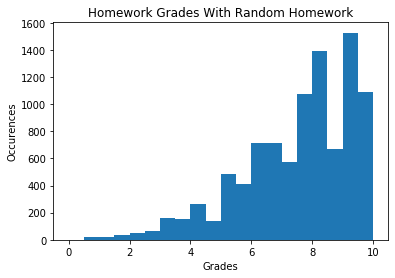

In [144]:
grades = get_grades()
just_make_a_graph(grades,'Homework Grades With Random Homework')

In [153]:
#data with focus was made
#data_maker_focus()

mean with all grades 7.331140823981158


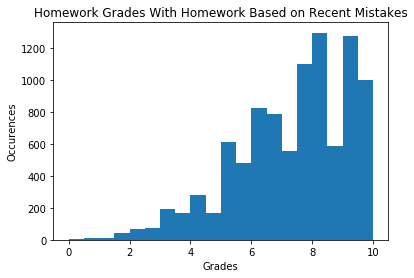

In [154]:
grades_with_focus = get_grades('_focus')
just_make_a_graph(grades_with_focus,'Homework Grades With Homework Based on Recent Mistakes')

mean with all grades 7.428095413893799


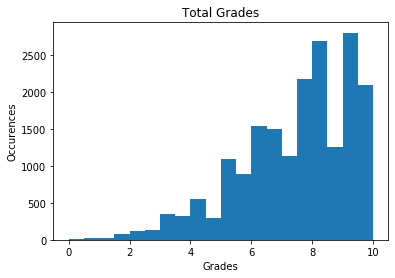

In [155]:
grades_total = grades + grades_with_focus
just_make_a_graph(grades_total,'Total Grades')

In [157]:
grades_total = np.array(grades_total)
size = int(len(grades_total)/2)
trials = 10**6
grades_mean = sum(grades)/len(grades)
grades_with_focus_mean = sum(grades_with_focus)/len(grades_with_focus)
mean_diffs=np.empty(trials)
for trial in tqdm(range(trials)):
    sample_1 = np.random.choice(grades_total,size,replace=True)
    sample_2 = np.random.choice(grades_total,size,replace=True)
    mean_diffs[trial] = np.mean(sample_1)-np.mean(sample_2)
p=np.sum(mean_diffs >= grades_mean-grades_with_focus_mean)
print('p =',p)


p = 0


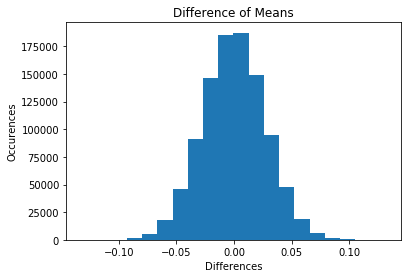

In [158]:
    plt.hist(mean_diffs,bins=20)
    plt.title('Difference of Means')
    plt.xlabel('Differences')
    plt.ylabel('Occurences')
    plt.show()

mean with all grades 7.772668318592409


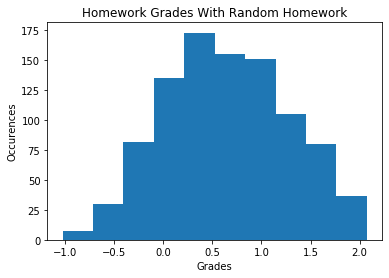

In [159]:
average_grades = data_frame_homework_percentages(50).Average
average_grades = np.array(average_grades)
just_make_a_log_graph(average_grades, 'Homework Grades With Random Homework')

mean with all grades 7.574929747099909


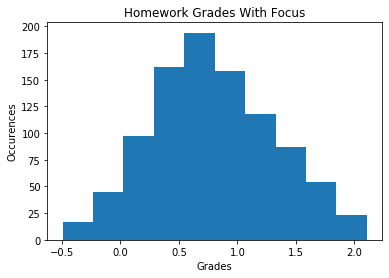

In [160]:
average_grades = data_frame_homework_percentages(50,'_focus').Average
average_grades = np.array(average_grades)
just_make_a_log_graph(average_grades, 'Homework Grades With Focus')

<h1>Adding Additional Problems</h1>

In [ ]:
#data with additional problems was made
#data_maker_additional()

mean with all grades 7.44246604961124


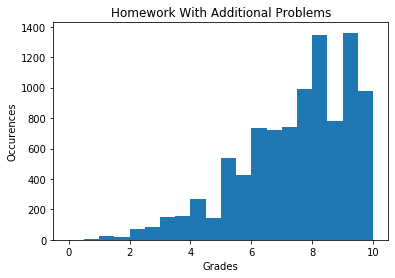

In [163]:
grades_additional = get_grades('_additional')
just_make_a_graph(grades_additional, 'Homework With Additional Problems')

mean with all grades 7.774836679520762


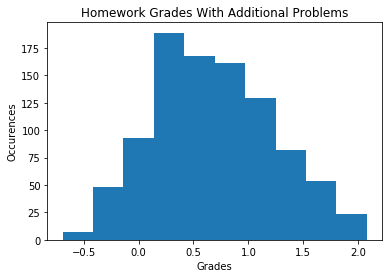

In [164]:
average_grades = data_frame_homework_percentages(50,'_additional').Average
average_grades = np.array(average_grades)
just_make_a_log_graph(average_grades, 'Homework Grades With Additional Problems')

<h1>Replacing Additional Problems</h1>

In [ ]:
#data with replacement was made
#data_maker_replace()

mean with all grades 7.423406988590318


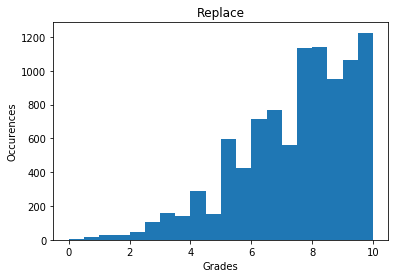

In [165]:
grades_additional = get_grades('_replace')
just_make_a_graph(grades_additional, 'Homework Grades With Replacement Problems')

mean with all grades 7.648812469961689


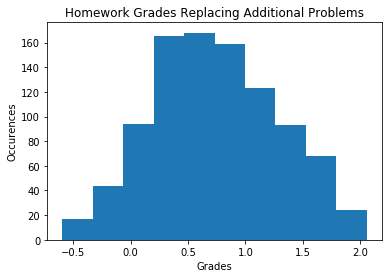

In [166]:
average_grades = data_frame_homework_percentages(50,'_replace').Average
average_grades = np.array(average_grades)
just_make_a_log_graph(average_grades, 'Homework Grades Replacing Additional Problems')

<h1>Appropriate Problems</h1>

In [ ]:
#data with appropriate was made
#data_maker_appropriate()

mean with all grades 7.548822041832532


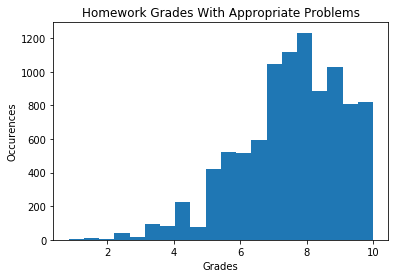

In [10]:
grades_additional = get_grades('_appropriate')
just_make_a_graph(grades_additional, 'Homework Grades With Appropriate Problems')

mean with all grades 7.832536974078861


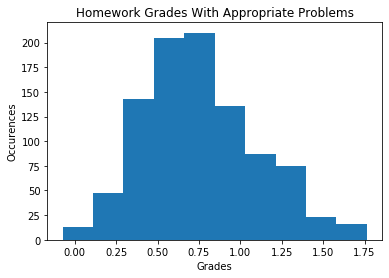

In [11]:
average_grades = data_frame_homework_percentages(50,'_appropriate').Average
average_grades = np.array(average_grades)
just_make_a_log_graph(average_grades, 'Homework Grades With Appropriate Problems')

<h1>Final Grades</h1>

mean with all grades 8.824233358264742


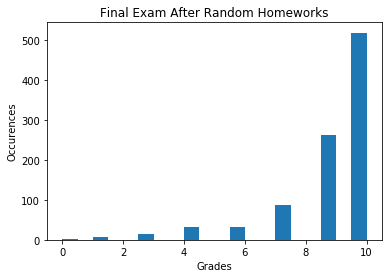

mean with all grades 7.678384442782303


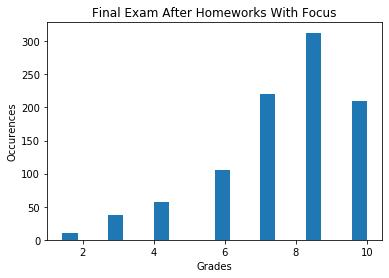

mean with all grades 8.844814260782812


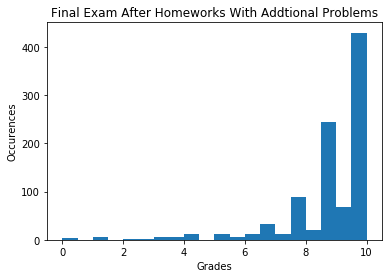

mean with all grades 8.711194215906232


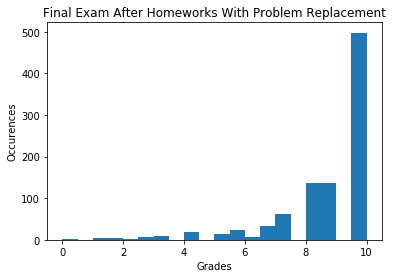

mean with all grades 8.76020942408377


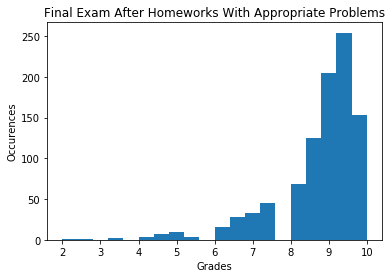

In [13]:
grades = data_frame_homework_score(51).Score
grades_focus = data_frame_homework_score(51,'_focus').Score
grades_additional = data_frame_homework_score(51, '_additional').Score
grades_replace = data_frame_homework_score(51,'_replace').Score
grades_appropriate = data_frame_homework_score(51,'_appropriate').Score

just_make_a_graph(grades, 'Final Exam After Random Homeworks')
just_make_a_graph(grades_focus, 'Final Exam After Homeworks With Focus')
just_make_a_graph(grades_additional, 'Final Exam After Homeworks With Addtional Problems')
just_make_a_graph(grades_replace, 'Final Exam After Homeworks With Problem Replacement')
just_make_a_graph(grades_appropriate, 'Final Exam After Homeworks With Appropriate Problems')


<h1>Grades by Week</h1>

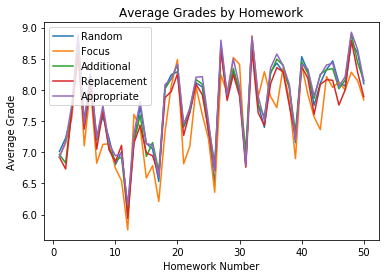

In [16]:
data_frame_skills = data_frame_grade_by_homework()
graph_grades_progression(data_frame_skills, 'Average Grades by Homework')

<h1>Skills by Week</h1>

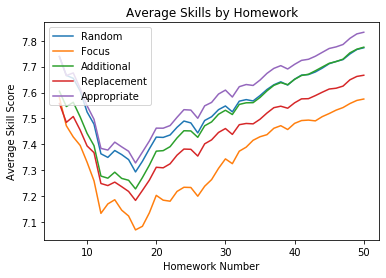

In [35]:
data_frame_skills = data_frame_skills_by_homework()
graph_skills_progression(data_frame_skills, 'Average Skills by Homework')

<h1>Summarizing Strengths and Weaknesses to the Students</h1>

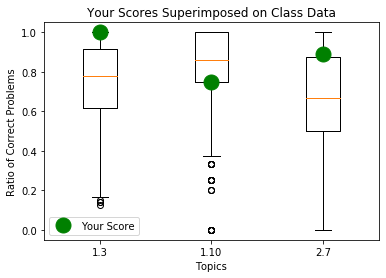

In [18]:
df = pd.read_csv(directory+'/hwdata/HW1.csv', index_col='email')
email = list(df.index)[0]
student_help_plot(email,10)